In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.ticker as mticker
import matplotlib
import matplotlib.dates as mdates
import numpy as np
import logging

sns.set(font_scale=1.4)
sns.set_style('whitegrid')

%matplotlib inline

In [2]:
train_data = pd.read_csv('archive/train.csv')
valid_data = pd.read_csv('archive/valid.csv')

In [3]:
def date_to_datetime(arg):
    return datetime.strptime(arg, '%Y-%m-%d %H:%M:%S')

In [4]:
train_data['CreationDate'] = train_data['CreationDate'].map(date_to_datetime)
train_data.sort_values('Y', inplace=True)
train_data

,Id,Title,Body,Tags,CreationDate,Y
22972,45310925,How to get a complete topic distribution for a...,<p>When I train my lda model as such</p>\n\n<p...,<python><gensim><lda>,2017-07-25 18:21:31,HQ
10972,39634954,nvm uninstall doesn't actually uninstall the n...,<p>So I'm trying to clear out older versions o...,<node.js><nvm>,2016-09-22 09:16:33,HQ
10974,39635861,Unable to contact local DTServiceHub to bless ...,<p>When I run my basic Xcode project in simula...,<ios><xcode8>,2016-09-22 09:54:23,HQ
10975,39637588,C# How to add a property setter in derived class?,<p>I have a requirement where I have a number ...,<c#><inheritance>,2016-09-22 11:19:19,HQ
10976,39637675,What is the difference between @types.coroutin...,<p>Documentations say:</p>\n\n<blockquote>\n ...,<python><asynchronous><python-3.5>,2016-09-22 11:23:13,HQ
...,...,...,...,...,...,...
31785,50165626,dice number showing with c# on unity 3d,I wrote a code to show the number of the dice ...,<c#><unity3d><3d>,2018-05-04 00:50:45,LQ_EDIT
31784,50163974,powershell generate word list from two csv fil...,I'm trying to use powershell to import two csv...,<powershell><csv>,2018-05-03 21:16:52,LQ_EDIT
13573,40687487,Why this regex is not working?,Test URL:\r\n\r\n www-test1.examples.com\r\...,<java><regex>,2016-11-18 23:28:06,LQ_EDIT
31792,50172042,installing packag (gahgu95av2.db) in R,I have a problem with installing pack (gahgu95...,<r>,2018-05-04 09:48:05,LQ_EDIT


In [5]:
valid_data['CreationDate'] = valid_data['CreationDate'].map(date_to_datetime)
valid_data.sort_values('Y', inplace=True)
valid_data

,Id,Title,Body,Tags,CreationDate,Y
5708,42226798,Remove duplicate data from query results,<p>I have the following query:</p>\n\n<pre><co...,<sql-server><tsql>,2017-02-14 12:56:30,HQ
5841,42394999,Why should I use Validators.compose()?,<p>I have a field I want to validate with mult...,<angular><angular2-forms><angular2-formbuilder>,2017-02-22 14:59:19,HQ
5839,42393545,"How to fix ""Missing Gradle project configurati...","<p>As an Eclipse user, I always liked the Grad...",<eclipse><gradle><configuration><buildship>,2017-02-22 13:58:32,HQ
5838,42390860,Configure active profile in SpringBoot via Maven,<p>I'm trying to set an active profile in Spri...,<java><spring><maven><spring-boot>,2017-02-22 12:01:00,HQ
5836,42389649,'openURL' was deprecated in iOS 10.0: Please u...,<p>I have working open webLink url codes in <c...,<ios><uiwebview><swift3>,2017-02-22 11:12:41,HQ
...,...,...,...,...,...,...
8218,46154987,How avoid recurrent code in block with ruby ?,I try to convert a bash script in a ruby scrip...,<ruby><linux>,2017-09-11 11:45:53,LQ_EDIT
8217,46150920,What is the best way (steps) to implement User...,Trying to use Apache Ignite as in-memory datab...,<java><ignite>,2017-09-11 08:06:24,LQ_EDIT
8214,46147329,Converting lower case hex to uppercase in python,Can anyone please help me in converting a hex ...,<python><string><mac-address>,2017-09-11 02:13:22,LQ_EDIT
8252,46189292,I want to get $username variable from profile....,This is my ajax code:\r\n \r\n\r\n\r\n\r\n ...,<javascript><php><mysql><ajax><fetch>,2017-09-13 05:10:39,LQ_EDIT


# EDA

## Labels distribution

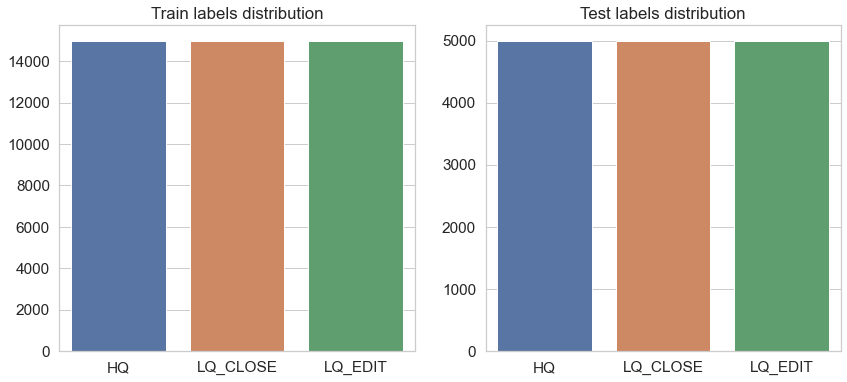

In [6]:
train_Y_vc = train_data['Y'].value_counts()
valid_Y_vc = valid_data['Y'].value_counts()


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=train_Y_vc.index, y=train_Y_vc.values, ax=axes[0])
axes[0].set_title('Train labels distribution')
sns.barplot(x=valid_Y_vc.index, y=valid_Y_vc.values, ax=axes[1])
axes[1].set_title('Test labels distribution')
plt.show()

#### Summary
 - Counts of labels are equal each other for both train and test datasets
 - Train dataset 3x times larger than test

In [7]:
datasets = [('Train', train_data), ('Test', valid_data)]

## Dates distribution

### Days distribution

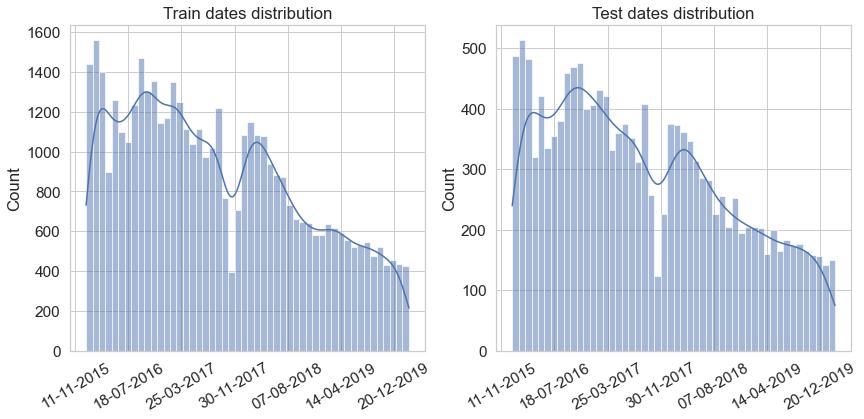

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate'].sort_values()
    def get_date(arg):
        return arg.date()
    CD_data_mapped = CD_data.map(get_date)
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

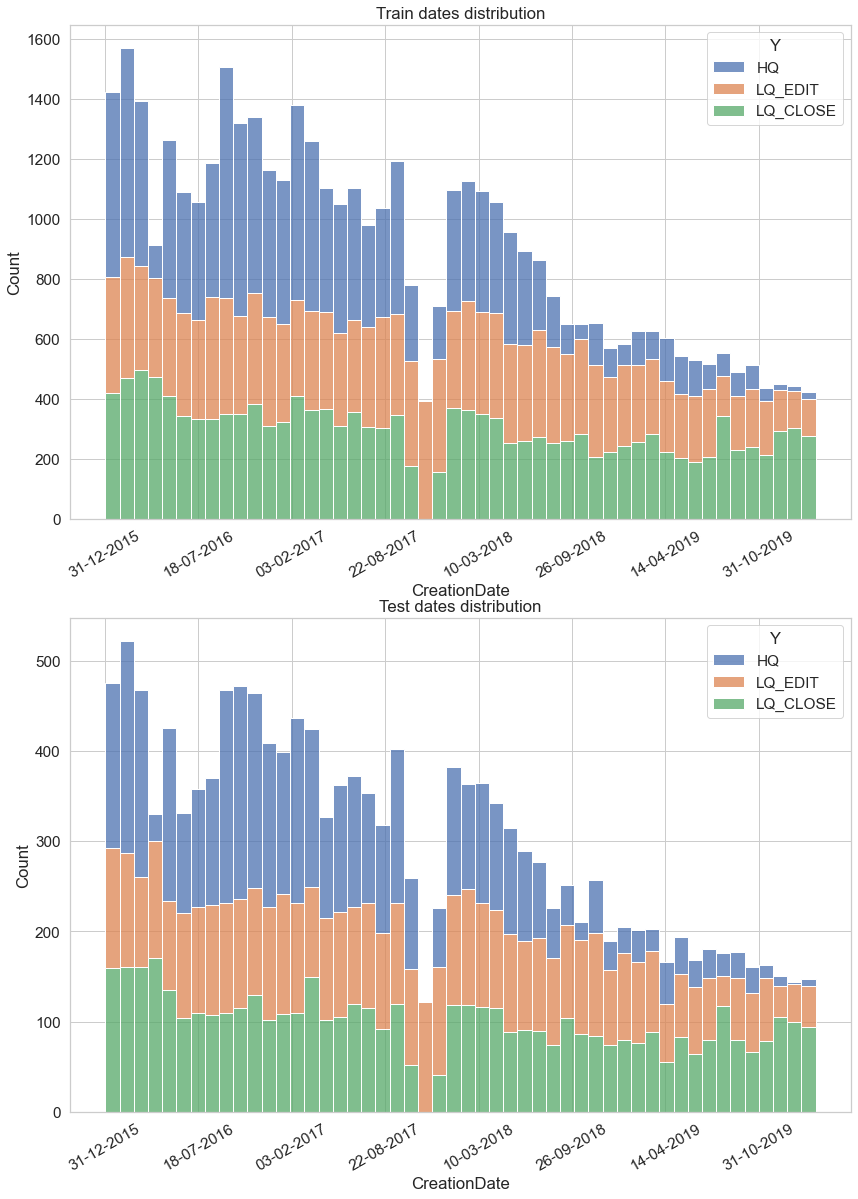

In [9]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']
anomaly_timeframes = {}

def search_anomaly_timeframe_bounds(CD_data):
    max_length = 0
    current_length = 0
    is_in_sector = False
    start_sector_idx = None
    max_start_sector_idx = None
    max_finish_sector_idx = None
    CD_data = CD_data.copy()
    for index, row in CD_data.iterrows():
        if row['Y'] == 'LQ_EDIT':
            if is_in_sector:
                current_length += 1
            else:
                is_in_sector = True
                current_length = 1
                start_sector_idx = index
        else:
            if current_length > max_length:
                max_length = current_length
                max_start_sector_idx = start_sector_idx
                max_finish_sector_idx = index
            is_in_sector = False
    return CD_data['CreationDate'][max_start_sector_idx], CD_data['CreationDate'][max_finish_sector_idx]
    
fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    CD_data.sort_values(by=['CreationDate'], inplace=True)
    anomaly_timeframes[dataset_name] = search_anomaly_timeframe_bounds(CD_data)
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx], 
                 palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} dates distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%d-%m-%Y')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

In [10]:
print('Timeframes with only LQ_EDIT samples:')
for key, value in anomaly_timeframes.items():
    print(f'{key} dataset : [{value[0]}, {value[1]}]')

Timeframes with only LQ_EDIT samples:
Train dataset : [2017-10-17 08:06:29, 2017-12-15 16:32:28]
Test dataset : [2017-10-17 05:57:57, 2017-12-15 18:01:33]


#### Summary
 - The graphs show the decrease in the number of HQ labels over time
 - Timeframe with only LQ_EDIT exists in both train and test datasets

### Daytimes distribution

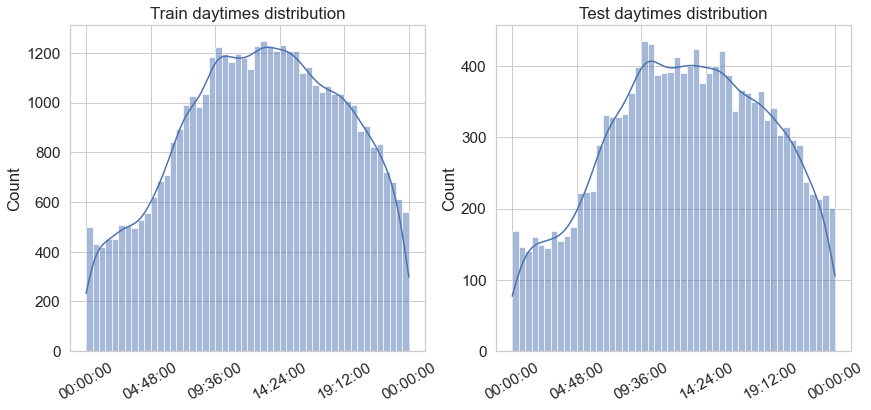

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset['CreationDate']
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data_mapped = CD_data.map(get_daytime).sort_values()
    sns.histplot(x=mdates.date2num(CD_data_mapped), bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

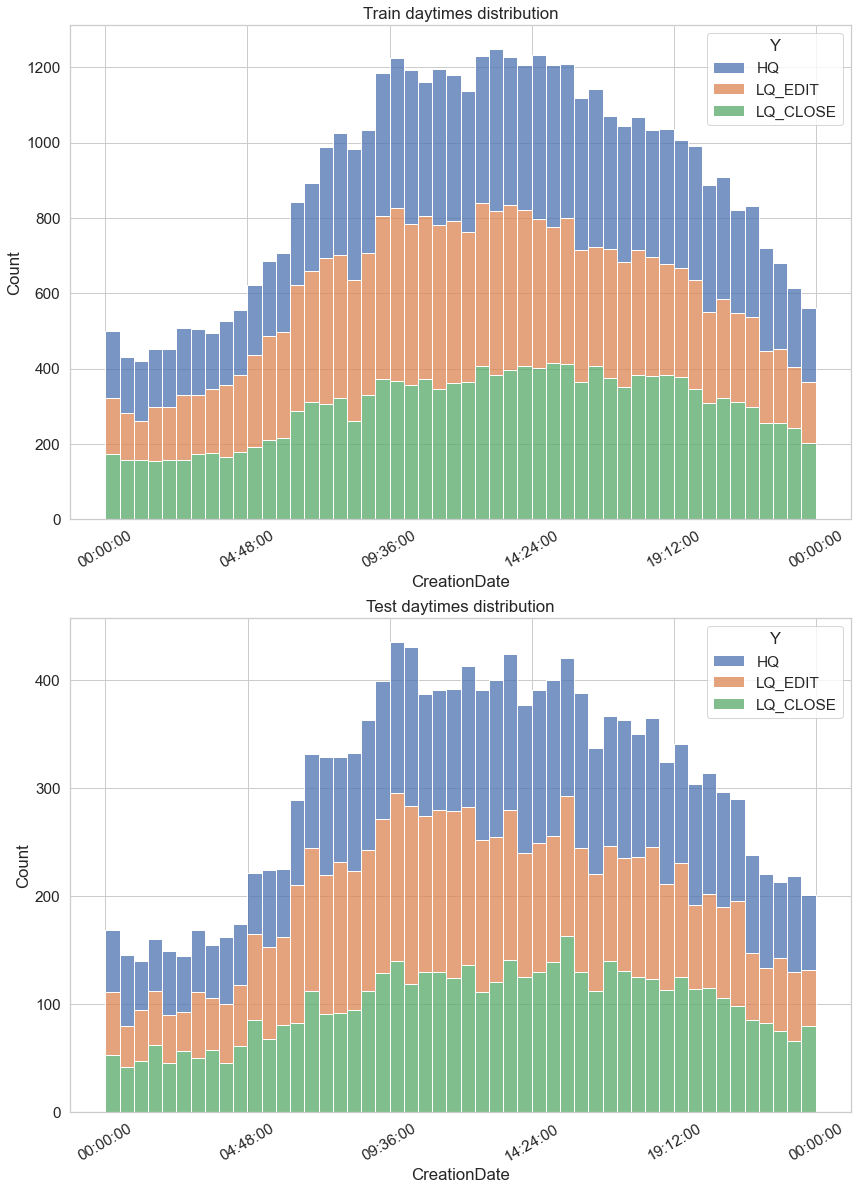

In [12]:
palette = {'HQ': 'C0', 'LQ_EDIT': 'C1', 'LQ_CLOSE': 'C2'}
hue_order = ['HQ', 'LQ_EDIT', 'LQ_CLOSE']

fig, axes = plt.subplots(2, 1, figsize=(14, 20))
for idx, (dataset_name, dataset) in enumerate(datasets):
    CD_data = dataset[['CreationDate', 'Y']].copy()
    def get_daytime(arg):
        str_time = arg.replace(year=2020, day=1, month=1)
        return str_time
    CD_data['CreationDate'] = CD_data['CreationDate'].map(get_daytime)
    CD_data.sort_values(by=['CreationDate'])
    CD_data['CreationDate'] = mdates.date2num(CD_data['CreationDate'])
    sns.histplot(data=CD_data, x='CreationDate', bins=50, multiple='stack', hue='Y', ax=axes[idx],
                palette=palette, hue_order=hue_order)
    axes[idx].set_title(f'{dataset_name} daytimes distribution')
    plt.setp(axes[idx].xaxis.get_ticklabels(), rotation=30)
    myFmt = mdates.DateFormatter('%H:%M:%S')
    axes[idx].xaxis.set_major_formatter(myFmt)
plt.show()

#### Summary
 - No insights

## Tags
### Find intersection of train and test datasets

In [13]:
def get_tags_counts(T_data):
    tags_dict = {}
    for item in T_data:
        if item[0] != '<' or item[-1] != '>':
            logging.error(f'Wrong format of tag: {item}')
        local_tags = item[1:-1].split('><')
        local_tags_set = set()
        for local_tag in local_tags:
            if local_tag in local_tags_set:
                continue
            local_tags_set.add(local_tag)
            if local_tag not in tags_dict.keys():
                tags_dict[local_tag] = 0
            tags_dict[local_tag] += 1
    return dict(sorted(tags_dict.items(), key=lambda item: -item[1]))

tags_dicts = {}
overall_keys = None

for idx, (dataset_name, dataset) in enumerate(datasets):
    T_data = dataset['Tags'].copy()
    tags_counts = get_tags_counts(T_data)
    print(f'Top 5 tags ({dataset_name} dataset):', sorted(tags_counts.items(), key=lambda item: -item[1])[:5])
    print(f'Tags count ({dataset_name} dataset):', len(tags_counts.keys()))
    tags_dicts[dataset_name] = tags_counts
    
overall_keys = tags_dicts['Train'].keys() & tags_dicts['Test'].keys()
print('Size of tags intersection on Train & Test datasets:', 
      len(overall_keys))

Top 5 tags (Train dataset): [('javascript', 5385), ('python', 5041), ('java', 4677), ('android', 3573), ('c#', 3137)]
Tags count (Train dataset): 9336
Top 5 tags (Test dataset): [('python', 1759), ('javascript', 1721), ('java', 1565), ('android', 1265), ('php', 1036)]
Tags count (Test dataset): 5401
Size of tags intersection on Train & Test datasets: 4034


### Get "tag X class" counts

In [14]:
overall_tags = []
overall_tags_df = {}

def init_stage_overall_tags():
    stage_overall_tags = {}
    for key in overall_keys:
        stage_overall_tags[key] = {}
        stage_overall_tags[key]['HQ'] = 0
        stage_overall_tags[key]['LQ_EDIT'] = 0
        stage_overall_tags[key]['LQ_CLOSE'] = 0
    return stage_overall_tags
    
for idx, (dataset_name, dataset) in enumerate(datasets):
    overall_tags.append(init_stage_overall_tags())
    stage_overall_tags = overall_tags[-1]
    T_data = dataset[['Tags', 'Y']].copy()
    for index, row in T_data.iterrows():
        tags = set(row['Tags'][1:-1].split('><'))
        for tag in tags:
            if tag in overall_keys:
                stage_overall_tags[tag][row['Y']] += 1
    overall_tags_df[dataset_name] = pd.DataFrame.from_dict(stage_overall_tags, orient='index')
    print(f'{dataset_name} tags:')
    print(overall_tags_df[dataset_name])
    

Train tags:
                       HQ  LQ_EDIT  LQ_CLOSE
packages                4        2         3
common-lisp             1        1         2
intrinsics              0        0         1
programming-languages   2        4         6
extension-methods       2        1         2
...                    ..      ...       ...
converters              0        3         4
nsurlsession            3        3         0
instructions            0        2         0
tizen                   1        0         1
pyqt                    1        1         2

[4034 rows x 3 columns]
Test tags:
                       HQ  LQ_EDIT  LQ_CLOSE
packages                4        0         0
common-lisp             0        1         0
intrinsics              1        0         0
programming-languages   0        0         1
extension-methods       1        0         0
...                    ..      ...       ...
converters              0        1         1
nsurlsession            0        1         0
instruc

### Get quantiles of tags counts distribution

In [15]:
for idx, (dataset_name, dataset) in enumerate(datasets):
    def sum_counts(row):
        return sum(row.values[:3])
    tags_counts = overall_tags_df[dataset_name].apply(sum_counts, axis=1)
    overall_tags_df[dataset_name]['Sum'] = tags_counts
    print(overall_tags_df[dataset_name])
    q = tags_counts.quantile(np.linspace(0.9,1,9))
    print(f'{dataset_name} quantiles')
    print(q)

                       HQ  LQ_EDIT  LQ_CLOSE  Sum
packages                4        2         3    9
common-lisp             1        1         2    4
intrinsics              0        0         1    1
programming-languages   2        4         6   12
extension-methods       2        1         2    5
...                    ..      ...       ...  ...
converters              0        3         4    7
nsurlsession            3        3         0    6
instructions            0        2         0    2
tizen                   1        0         1    2
pyqt                    1        1         2    4

[4034 rows x 4 columns]
Train quantiles
0.9000      32.0000
0.9125      37.0000
0.9250      45.0000
0.9375      55.9375
0.9500      71.0000
0.9625      95.7625
0.9750     154.0000
0.9875     282.7625
1.0000    5385.0000
dtype: float64
                       HQ  LQ_EDIT  LQ_CLOSE  Sum
packages                4        0         0    4
common-lisp             0        1         0    1
intrinsics    

### Summary
 - Most part of tags appear rare. Others appear very often.

### Get good & rare tags

In [16]:
# Drop extra tags for visualization. count_limit provide opportunity to drop rare tags.
count_limit = 200

train_data = overall_tags_df['Train']
good_tags_index = train_data[train_data['Sum'] > count_limit]
rare_tags_index = train_data[train_data['Sum'] <= count_limit]
print('Good tags')
print(good_tags_index)
print('Tags at all:', sum(good_tags_index['Sum'].values))
good_tags_index = good_tags_index.index
print()
print('Rare tags')
print(rare_tags_index)
print('Tags at all:', sum(rare_tags_index['Sum'].values))
rare_tags_index = rare_tags_index.index

Good tags
                      HQ  LQ_EDIT  LQ_CLOSE   Sum
loops                 13      123       100   236
php                  296     1124      1705  3125
android             1264     1429       880  3573
dictionary            31      103        97   231
linux                109      130       242   481
...                  ...      ...       ...   ...
tensorflow           206       14        15   235
visual-studio-code   208        8         9   225
git                  248       25        57   330
date                  33       80       121   234
c++                  413      694      1156  2263

[75 rows x 4 columns]
Tags at all: 63413

Rare tags
                       HQ  LQ_EDIT  LQ_CLOSE  Sum
packages                4        2         3    9
common-lisp             1        1         2    4
intrinsics              0        0         1    1
programming-languages   2        4         6   12
extension-methods       2        1         2    5
...                    ..      ...   

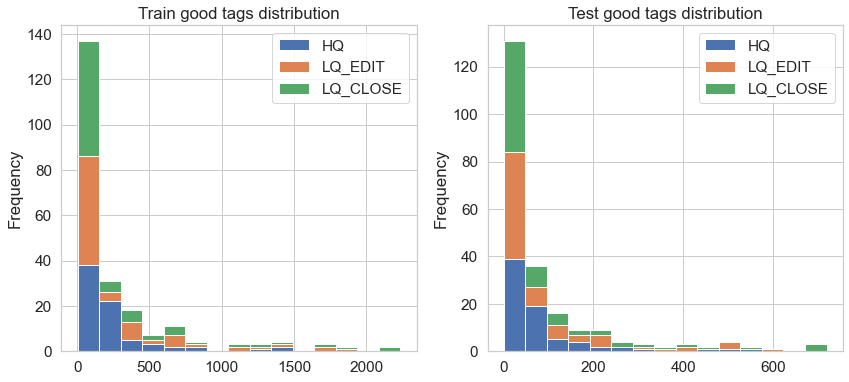

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[good_tags_index]
    tags_x_class.plot.hist(bins=15, stacked='True', title=f'{dataset_name} good tags distribution', ax=axes[idx])

### Analyse rare tags with Gini coef
https://en.wikipedia.org/wiki/Gini_coefficient

In [18]:
def gini_coef(coefs):
    s = sum(coefs)
    arith_mean = s / len(coefs)
    acc = 0
    for i in coefs:
        for j in coefs:
            acc += abs(i - j)
    acc /= (2 * len(coefs) ** 2 * arith_mean)
    return acc

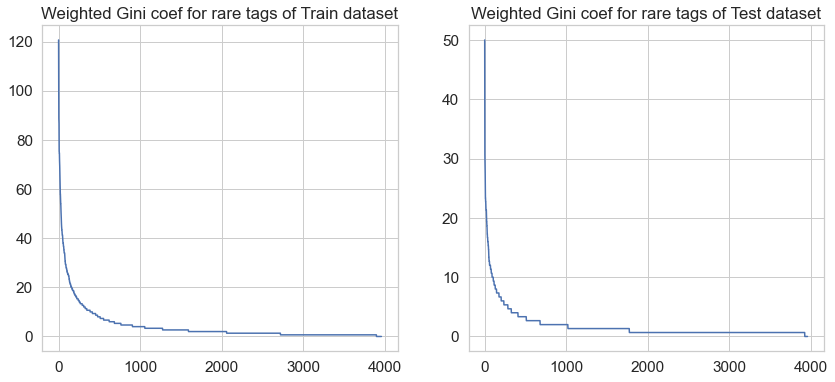

In [19]:
# To prevent overfitting on very-very rare tags we'll multiply Gini coef on sum of coefs
def weighted_gini_coef(coefs):
    return gini_coef(coefs) * sum(coefs)

rare_tags = {}

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, (dataset_name, dataset) in enumerate(datasets):
    local_tags = overall_tags_df[dataset_name].copy().drop(['Sum'], axis=1)
    tags_x_class = local_tags.loc[rare_tags_index]
    rare_tags_scores = tags_x_class.apply(weighted_gini_coef, axis=1).sort_values(ascending=False)
    sns.lineplot(data=rare_tags_scores.values, ax=axes[idx])
    axes[idx].set_title(f'Weighted Gini coef for rare tags of {dataset_name} dataset')
    rare_tags[dataset_name] = rare_tags_scores

### Analyze Train over Test Gini coef relations

In [20]:
def analyze_gini_relations(count_limit=1e9):
    gini_relations = []
    fig, ax = plt.subplots(figsize=(7, 6))
    print('Actual train Gini coefs')
    print(rare_tags['Train'])
    limit_idx = 0
    for tag in rare_tags['Train'].index:
        if limit_idx >= count_limit:
            break
        limit_idx += 1
        train_tag_scores = rare_tags['Train'].loc[tag]
        test_tag_scores = rare_tags['Test'].loc[tag]
        if (train_tag_scores != 0 and test_tag_scores != 0):
            gini_relations.append(train_tag_scores / test_tag_scores)
    sns.scatterplot(data=gini_relations, ax=ax, alpha=0.7)
    print()
    print('Quantiles')
    print(pd.DataFrame(gini_relations).quantile([0.1, 0.25, 0.5, 0.75, 0.9, 1]))
    return 

Actual train Gini coefs
dart          120.666667
npm           102.666667
.net-core      91.333333
kubernetes     88.666667
vb.net         87.333333
                 ...    
mp3             0.000000
callkit         0.000000
filestream      0.000000
onesignal       0.000000
phpexcel        0.000000
Length: 3959, dtype: float64

Quantiles
             0
0.10  2.393429
0.25  2.651116
0.50  3.161458
0.75  3.684028
0.90  4.107237
1.00  6.833333


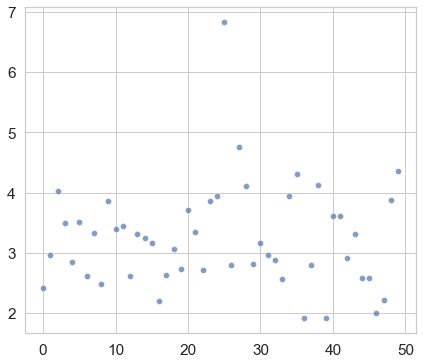

In [21]:
analyze_gini_relations(50)

### Summary
 - At least first 50 rare tags have non-uniform distribution on classes (for both train and test datasets)

Actual train Gini coefs
dart          120.666667
npm           102.666667
.net-core      91.333333
kubernetes     88.666667
vb.net         87.333333
                 ...    
mp3             0.000000
callkit         0.000000
filestream      0.000000
onesignal       0.000000
phpexcel        0.000000
Length: 3959, dtype: float64

Quantiles
              0
0.10   2.191234
0.25   2.587010
0.50   3.177083
0.75   3.866477
0.90   4.516667
1.00  15.333333


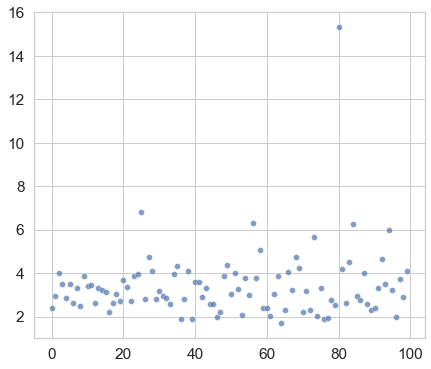

In [22]:
analyze_gini_relations(100)

Actual train Gini coefs
dart          120.666667
npm           102.666667
.net-core      91.333333
kubernetes     88.666667
vb.net         87.333333
                 ...    
mp3             0.000000
callkit         0.000000
filestream      0.000000
onesignal       0.000000
phpexcel        0.000000
Length: 3959, dtype: float64

Quantiles
         0
0.10   1.0
0.25   1.0
0.50   2.0
0.75   3.0
0.90   4.5
1.00  26.0


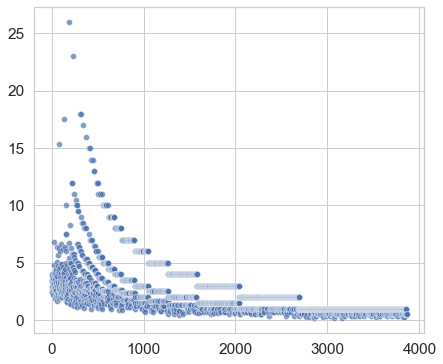

In [23]:
analyze_gini_relations()

In [24]:
interesting_rare_indes = rare_tags['Train'].index[:50]

In [25]:
interesting_rare_indes

Index(['dart', 'npm', '.net-core', 'kubernetes', 'vb.net', 'gradle',
       'ecmascript-6', 'macos', 'intellij-idea', 'docker-compose', 'winforms',
       'unit-testing', 'redux', 'google-chrome', 'jenkins', 'tsql', 'pointers',
       'keras', 'perl', 'vuejs2', 'math', 'postgresql', 'github', 'batch-file',
       'visual-studio-2017', 'apache-spark', 'object', 'numpy', 'variables',
       'swiftui', 'class', 'dockerfile', 'mysqli', 'file', 'rxjs', 'c++17',
       'azure', 'arraylist', 'jupyter-notebook', 'web', 'angular-cli', 'csv',
       'amazon-s3', 'matlab', 'wpf', 'mongodb', 'sqlite', 'codeigniter',
       'swift3', 'random'],
      dtype='object')